# Notebook with Face recognition (Triplet)
© Реализовать Triplet loss, обучить сеть с нуля на нем. Добиться accuracy на тестовой части >0.7.

In [1]:
import random
import os
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from torch.nn.functional import normalize
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.io import read_image

WORKING_DIR = '/kaggle/working'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

Using device: cuda


In [2]:
def set_seed(seed):
    random.seed(seed)                      # Фиксация сидов для встроенного модуля random
    np.random.seed(seed)                   # Фиксация сидов для NumPy
    torch.manual_seed(seed)                # Фиксация сидов для PyTorch
    torch.cuda.manual_seed(seed)           # Фиксация сидов для CUDA
    torch.cuda.manual_seed_all(seed)       # Фиксация сидов для всех устройств CUDA
    torch.backends.cudnn.deterministic = True  # Обеспечивает детерминированное поведение CUDNN
    torch.backends.cudnn.benchmark = False     # Отключает эвристики CUDNN для детерминированности

set_seed(42)

## Download data from gdrive

In [3]:
# celebA_imgs.rar - An archive (a folder) with pictures
!gdown 1Anlz7R3KtyOwJB5ouVtELt1kU2QKNw1f
# celebA_train_split.txt - File with train/val/test split info 
!gdown 1tOKP0hmpaj7aMwOp6igZPuk2lBNxlwWK
# celebA_anno.txt - File with annotation - each picture from celebA_imgs is assigned its id
!gdown 1V3m3anz8gghYOLCYtlpQ1A6Qs1LKcBUB

Downloading...
From (original): https://drive.google.com/uc?id=1Anlz7R3KtyOwJB5ouVtELt1kU2QKNw1f
From (redirected): https://drive.google.com/uc?id=1Anlz7R3KtyOwJB5ouVtELt1kU2QKNw1f&confirm=t&uuid=4492db4c-4b0d-4aa0-88a8-1550a861b362
To: /kaggle/working/celebA_imgs.rar
100%|████████████████████████████████████████| 168M/168M [00:04<00:00, 39.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tOKP0hmpaj7aMwOp6igZPuk2lBNxlwWK
To: /kaggle/working/celebA_train_split.txt
100%|████████████████████████████████████████| 156k/156k [00:00<00:00, 86.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V3m3anz8gghYOLCYtlpQ1A6Qs1LKcBUB
To: /kaggle/working/celebA_anno.txt
100%|█████████████████████████████████████████| 177k/177k [00:00<00:00, 106MB/s]


In [4]:
# Package for unarchive
!pip install patool
import patoolib
patoolib.extract_archive(f"{WORKING_DIR}/celebA_imgs.rar", outdir="celebA_imgs")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 2.9 MB/s eta 0:00:00


INFO patool: Extracting /kaggle/working/celebA_imgs.rar ...
INFO patool: ... creating output directory `celebA_imgs'.
INFO patool: running /usr/bin/unrar x -kb -or -- /kaggle/working/celebA_imgs.rar
INFO patool: ... /kaggle/working/celebA_imgs.rar extracted to `celebA_imgs'.


'celebA_imgs'

## Parse input data

In [5]:
celeba_anno = pd.read_csv(f"{WORKING_DIR}/celebA_anno.txt", sep=" ", names=['path', 'id'])
celeba_train_split = pd.read_csv(f"{WORKING_DIR}/celebA_train_split.txt", sep=" ", names=['path', 'type'])

mapping = {0: 'train', 1: 'test', 2: 'val'}
celeba_train_split.replace({'type': mapping}, inplace=True)

celeba_train_split['type'].value_counts()

type
train    8544
test     1878
val      1589
Name: count, dtype: int64

In [6]:
def add_pathes(l, fill_to):
    total_len = len(l)
    if total_len < fill_to:
        l *= 1 + fill_to//total_len
        l = l[:fill_to]
    return l

def crop_image(image):
    """Custom advised crop"""
    image = image[:, 77:-41, 45:-50]
    return image

class CelebaImageDataset(Dataset):
    def __init__(
        self,
        annotations_file,
        img_dir,
        train_test_split_file=None,
        transform=None,
        target_transform=None
    ):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.train_test_labels = train_test_split_file
        self.transform = transform
        self.target_transform = target_transform

        self.img_labels = self.img_labels.reset_index(drop=True)
    
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path).to(DEVICE)
        label = torch.tensor(self.img_labels.iloc[idx, 1]).to(DEVICE)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

    def get_sample_dataset(self, type_dataset):
        img_labels = self.img_labels
        train_test_labels = self.train_test_labels
        
        sample = img_labels.merge(train_test_labels, on='path', how='inner')
        sample = sample[sample['type'] == type_dataset]

        sample_dataset = CelebaImageDataset(
            annotations_file=sample,
            img_dir=self.img_dir,
            train_test_split_file=self.train_test_labels,
            transform=self.transform,
        )
        return sample_dataset

    def fill_train_data(self, fill_to):
        """
        Fill the (only train!) data in the dataset so that there are at least `fill_to` representatives of each class
        """
        grouped_img_labels = (
            self.img_labels
            .groupby('id')
            .agg(path=pd.NamedAgg(column="path", aggfunc=lambda x: x.tolist()))
            .reset_index()
        )
        grouped_img_labels['path'] = grouped_img_labels['path'].apply(lambda x: add_pathes(x, fill_to))
        exploded_grouped_img_labels = grouped_img_labels.explode('path', ignore_index=True)
        exploded_grouped_img_labels = exploded_grouped_img_labels.merge(self.train_test_labels, on='path', how='inner')
        self.img_labels = exploded_grouped_img_labels[['path', 'id', 'type']]

In [7]:
from torch.utils.data import BatchSampler

# Пишем свой даталоадер, который гарантированно будет генерить батчи так,
# чтобы в батче было по 4 картинки каждого класса, что надо для реализации triplet loss'а по стратегии batch hard

class TripletBatchSampler(BatchSampler):
    def __init__(self, dataset, batch_size, K=4):
        self.dataset = dataset
        self.batch_size = batch_size
        self.P = batch_size // K
        self.K = K

        self.classes = np.unique(self.dataset.img_labels['id'])
        self.num_classes = len(self.classes)

    
    def __iter__(self):
        observations = self.dataset.img_labels.copy()
        
        custom_batches = []

        # print(len(observations))
        while len(observations) != 0:
            current_batch = []
            classes = np.unique(observations['id'])

            if len(classes) < self.P:
                classes_to_batch = classes
            else:
                classes_to_batch = np.random.choice(classes, size=self.P, replace=False)
                
            for label in classes_to_batch:
                filtered_dataset = observations[observations['id'] == label]
                
                indices_to_batch = np.random.choice(
                    filtered_dataset.index,
                    size=self.K,
                    replace=(len(filtered_dataset) < self.K)
                )

                current_batch.extend(indices_to_batch)

            observations.drop(index=current_batch, inplace=True)
            # Skip unrelevant batches 
            if (len(np.unique(current_batch)) < self.batch_size//2):
                # or (len(current_batch) < self.batch_size):
                continue
                
            custom_batches.append(current_batch)
            
        return iter(custom_batches)

    def __len__(self):
        # approx
        return int(1.145 * len(self.dataset) / self.batch_size)

In [8]:
celeba_image_dataset = CelebaImageDataset(
    annotations_file=celeba_anno,
    img_dir=f"{WORKING_DIR}/celebA_imgs/celebA_imgs",
    train_test_split_file=celeba_train_split,
    transform=crop_image, 
)

train_image_dataset = celeba_image_dataset.get_sample_dataset(type_dataset='train')
test_image_dataset = celeba_image_dataset.get_sample_dataset(type_dataset='test')
val_image_dataset = celeba_image_dataset.get_sample_dataset(type_dataset='val')

# Fill train data up to 50 observations on each class (8544 -> 25000)
train_image_dataset_filled = deepcopy(train_image_dataset)
train_image_dataset_filled.fill_train_data(fill_to=50)

BATCH_SIZE = 64

# train_dataloader = DataLoader(train_image_dataset, batch_size=BATCH_SIZE, shuffle=True)
# train_dataloader_filled = DataLoader(train_image_dataset_filled, batch_size=BATCH_SIZE, shuffle=True)
# test_dataloader = DataLoader(test_image_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_dataloader = DataLoader(val_image_dataset, batch_size=BATCH_SIZE, shuffle=False)


train_triplet_sampler = TripletBatchSampler(train_image_dataset, batch_size=BATCH_SIZE, K=4)
train_triplet_sampler_f = TripletBatchSampler(train_image_dataset_filled, batch_size=BATCH_SIZE, K=4)
test_triplet_sampler = TripletBatchSampler(test_image_dataset, batch_size=BATCH_SIZE, K=4)
val_triplet_sampler = TripletBatchSampler(val_image_dataset, batch_size=BATCH_SIZE, K=4)


train_triplet_dataloader = DataLoader(train_image_dataset, batch_sampler=train_triplet_sampler)
train_triplet_dataloader_f = DataLoader(train_image_dataset_filled, batch_sampler=train_triplet_sampler_f)
test_triplet_dataloader = DataLoader(test_image_dataset, batch_sampler=test_triplet_sampler)
val_triplet_dataloader = DataLoader(val_image_dataset, batch_sampler=val_triplet_sampler)

In [9]:
def render_tensor(img, device):
    if str(device) == 'cuda':
        plt.imshow(torch.permute(img, (1, 2, 0)).cpu())
    else:
        plt.imshow(torch.permute(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    return

Feature batch shape: torch.Size([64, 3, 100, 83])
Labels batch shape: torch.Size([64])
Label: 361


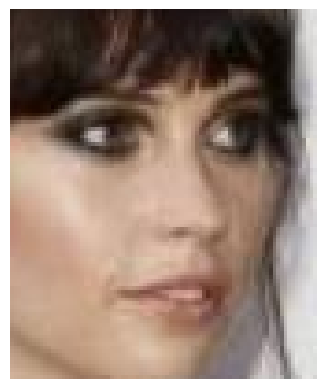

In [10]:
# Watching an image which fed into model
train_features, train_labels = next(iter(train_triplet_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
print(f"Label: {label}")
render_tensor(img, DEVICE)

---

## TripletLoss realization

In [11]:
# блок функций, необходимый для реализации triplet loss'а

def dist(a, b):
    norm = torch.norm(a - b, p=2)
    distance = norm * norm
    return distance


def find_unsimilar_pos(X: torch.Tensor, y: torch.Tensor, idx, dist_func):
    # Функция, которая находит самый далекий эмбеддинг того же класса
    label = y[idx]
    pos_indices = (y == label).nonzero(as_tuple=True)[0]
    pos_other_indices = pos_indices[pos_indices != idx]

    emb_a = X[idx]
    embeddings_p = X[pos_other_indices]

    distances = dist_func(emb_a.unsqueeze(0), embeddings_p)
    farthest_dist, _ = distances.max(dim=0)  # Максимальное расстояние

    return farthest_dist


def find_similar_neg(X: torch.Tensor, y: torch.Tensor, idx, dist_func):
    # Функция, которая находит самый близкий эмбеддинг другого класса
    label = y[idx]
    neg_indices = (y != label).nonzero(as_tuple=True)[0]

    emb_a = X[idx]
    embeddings_n = X[neg_indices]

    distances = dist_func(emb_a.unsqueeze(0), embeddings_n)
    nearest_dist, _ = distances.min(dim=0)

    return nearest_dist

In [12]:
class TripletLoss(nn.Module):
    def __init__(self, dist_func, margin=1):
        super(TripletLoss, self).__init__()
        self.dist_func = dist_func
        self.margin = margin
        
    def forward(self, embeddings, targets):
        positive_distances = []
        negative_distances = []
        
        for idx, emb in enumerate(embeddings):
            positive_distances.append(find_unsimilar_pos(embeddings, targets, idx, self.dist_func))
            negative_distances.append(find_similar_neg(embeddings, targets, idx, self.dist_func))

        positive_distances = torch.stack(positive_distances)
        negative_distances = torch.stack(negative_distances)

        loss = positive_distances - negative_distances + self.margin
        zeros = torch.zeros_like(loss)
        loss_s = torch.maximum(loss, zeros)
        loss_s = loss_s.mean()
        
        return loss_s

In [13]:
triplet_loss = TripletLoss(dist_func=dist)

## Load model

In [14]:
class EfficientNet2(nn.Module):
    def __init__(self, pretrained=False, num_classes=500):
        super(EfficientNet2, self).__init__()
        self.model = models.efficientnet_b2(weights=pretrained)

        embedding_size = 1408
        
        # Change embedding size
        self.model.features[8] = nn.Sequential(
            # 352 = self.model.features[8].Conv2d.in_features but not sure
            nn.Conv2d(352, embedding_size, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(embedding_size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.SiLU(inplace=True)
        )
        
        # Change out_features of last FC-layer
        self.model.classifier[1] = nn.Linear(embedding_size, num_classes, bias=False)
    
    def forward(self, x):
        embeddings = self.model.avgpool(self.model.features(x))
        embeddings = embeddings.squeeze()
        output = self.model.classifier(embeddings)
        last_layer_weight = self.model.classifier[1].weight

        return output, embeddings, last_layer_weight

In [15]:
display(len(train_triplet_dataloader.dataset))
display(len(train_triplet_dataloader_f.dataset))

8544

25000

## Train model

In [16]:
def custom_norm(x):
    return x/255

normalize_transformer = transforms.Compose([
        custom_norm,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Resize((224, 224)),
    ])

augment_n_normalize_transformer = transforms.Compose([
        # augmentations
        transforms.RandomHorizontalFlip(),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.4),
        transforms.RandomAdjustSharpness(sharpness_factor=0.5, p=0.4),
        transforms.ColorJitter(brightness=0.7, contrast=0.7, saturation=0.7, hue=0.12),
        transforms.RandomRotation(degrees=(-6, 6)),
        transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
        # normalizations
        normalize_transformer
    ])

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = augment_n_normalize_transformer(X)
        pred, embeddings, weights = model(X)
        normalized_embeddings = normalize(embeddings).squeeze().type(torch.float64)
        loss = loss_fn(embeddings=normalized_embeddings, targets=y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test_loop(dataloader, model, loss_fn, prefix):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = normalize_transformer(X)
            pred, embeddings, weights = model(X)
            normalized_embeddings = normalize(embeddings).squeeze().type(torch.float64)
            loss = loss_fn(embeddings=normalized_embeddings, targets=y)
            test_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test-{prefix} Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

    return correct, test_loss

In [17]:
def train_model(model, train_dataloader, test_dataloader, val_dataloader, loss_fn, optimizer, epochs):
    train_losses = []; test_losses = []; val_losses = [];
    train_accs = []; test_accs = []; val_accs = [];

    for t in range(epochs):
        print(f"__________ Epoch {t+1} __________")
        train_loop(train_triplet_dataloader_f, model, loss_fn, optimizer)
        train_acc, train_loss = test_loop(train_dataloader, model, loss_fn, prefix='train')
        test_acc, test_loss = test_loop(test_dataloader, model, loss_fn, prefix='test')
        val_acc, val_loss = test_loop(val_dataloader, model, loss_fn, prefix='val')
        
        train_losses.append(train_loss); test_losses.append(test_loss); val_losses.append(val_loss)
        train_accs.append(train_acc); test_accs.append(test_acc); val_accs.append(val_acc)
        print()

    metrics = {
        'losses': {
            'train': train_losses,
            'test': test_losses,
            'val': val_losses},
        'accs': {
            'train': train_accs,
            'test': test_accs,
            'val': val_accs}
    }
    
    return metrics


---

In [18]:
learning_rate = 4e-4
epochs = 70

In [19]:
efnet2 = EfficientNet2(pretrained=False).to(DEVICE)
optimizer = torch.optim.AdamW(efnet2.parameters(), lr=learning_rate)
history = train_model(efnet2, train_triplet_dataloader, test_triplet_dataloader, val_triplet_dataloader, triplet_loss, optimizer, epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


__________ Epoch 1 __________
Test-train Error: 
 Accuracy: 0.1%, Avg loss: 0.000677
Test-test Error: 
 Accuracy: 0.1%, Avg loss: 0.001242
Test-val Error: 
 Accuracy: 0.5%, Avg loss: 0.000000

__________ Epoch 2 __________
Test-train Error: 
 Accuracy: 0.2%, Avg loss: 0.038339
Test-test Error: 
 Accuracy: 0.2%, Avg loss: 0.056757
Test-val Error: 
 Accuracy: 0.6%, Avg loss: 0.077090

__________ Epoch 3 __________
Test-train Error: 
 Accuracy: 0.2%, Avg loss: 0.012508
Test-test Error: 
 Accuracy: 0.3%, Avg loss: 0.022306
Test-val Error: 
 Accuracy: 0.3%, Avg loss: 0.030530

__________ Epoch 4 __________
Test-train Error: 
 Accuracy: 0.2%, Avg loss: 0.177434
Test-test Error: 
 Accuracy: 0.2%, Avg loss: 0.257807
Test-val Error: 
 Accuracy: 0.3%, Avg loss: 0.238135

__________ Epoch 5 __________
Test-train Error: 
 Accuracy: 0.2%, Avg loss: 0.029943
Test-test Error: 
 Accuracy: 0.2%, Avg loss: 0.046710
Test-val Error: 
 Accuracy: 0.3%, Avg loss: 0.056979

__________ Epoch 6 __________
Test-

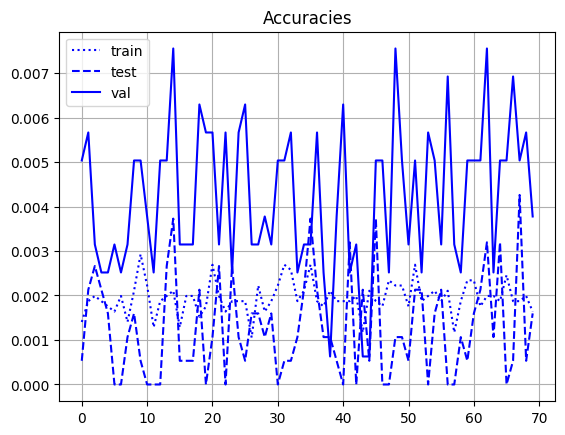

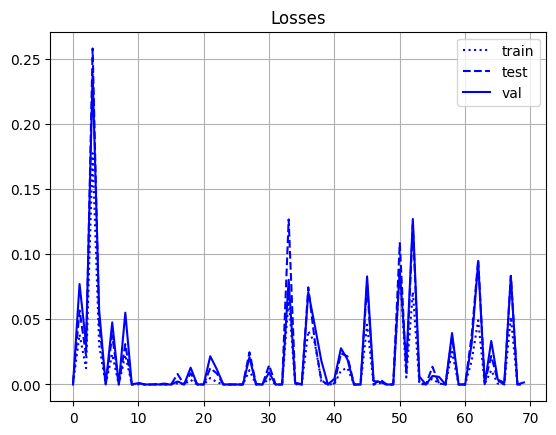

In [20]:
plt.title('Accuracies')

plt.plot(range(epochs), history['accs']['train'], label='train', linestyle='dotted', color='b')
plt.plot(range(epochs), history['accs']['test'], label='test', linestyle='dashed', color='b')
plt.plot(range(epochs), history['accs']['val'], label='val', linestyle='solid', color='b')

plt.grid()
plt.legend()
plt.show()

plt.title('Losses')

plt.plot(range(epochs), history['losses']['train'], label='train', linestyle='dotted', color='b')
plt.plot(range(epochs), history['losses']['test'], label='test', linestyle='dashed', color='b')
plt.plot(range(epochs), history['losses']['val'], label='val', linestyle='solid', color='b')

plt.grid()
plt.legend()
plt.show()

In [21]:
torch.save(efnet2.state_dict(), f"./triplet_trained_efnet2.pt")